In [1]:
import numpy as np
import time
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

In [2]:
def create_starting_optic(thick,R,k=-1,N=100):
    z=np.linspace(0,thick,N) #solves the problem of not having enough points close to the origin
    r=np.sqrt(2*R*z-(k+1)*z**2) 
    optic=np.array([z,r])
    return optic

In [3]:
def find_local_eq(r,optic):
    # first find nearest point in the lens array to where the ray r intersects
    z=optic[0]
    opt=optic[1]
    index=np.abs(opt-r).argmin()
    
    # isolate a few points around the closest index (look into how many points we actually want)
    lower=index-3 if index-3>0 else 0
    upper=index+3
        
    local_z=np.array(z[lower:upper])
    local_opt=np.array(opt[lower:upper])-r
    
    local_z=local_z[::-1]
    local_opt=-1*local_opt[::-1]
    # Use cubic spline to interpolate the local points
    # need to switch the z and the r coordinates so that cubic spline won't give error
    cs=None
    try:
        cs=CubicSpline(local_opt,local_z)
    except:
        print(local_opt)
        print(lower)
        print(upper)
    #zs=np.linspace(local_z[0],local_z[-1],N) 
    return cs

In [4]:
def find_reflect_slope(norm):
    theta=np.arctan(norm)
    slope=np.tan(2*theta)
    return slope

In [5]:
def raytrace(optic, exp_f, Nr=7, linsp=True):
    #create the starting rays
    opt=optic[1]
    # make sure that the rays are bounded 
    r_min=opt[1]
    r_max=opt[10]
    
    rays=np.linspace(r_min,r_max,Nr) if linsp else np.geomspace(r_min,r_max,Nr) #confine the rays to the diameter of the optic
    rays[rays==0]=1e-9 # if r=0 exists set to small value so we don't get infinity values
    raymatrix=[] # 3 points: before, at, after the optic
    after=[]
    for r in rays:
        cs=find_local_eq(r,optic)
        z_optic=cs(0)        
        norm=cs(0,1) #The normal is just the derivative 
        slope=find_reflect_slope(norm)
        r_after=slope*(exp_f-z_optic)+r # This is where the ray meets z=exp_f
        z_bef=exp_f*1.5 # change this so that z_bef all starts at the same z value
        z_ray=[z_bef,z_optic,exp_f]
        r_ray=[r,r,r_after]            
        raymatrix.append([z_ray,r_ray])
        after.append(r_after)
        #np.concatenate(raymatrix)
    return np.array(raymatrix),np.array(after)

In [6]:
def plot(optic,raymatrix,exp_f,title, lambda0=None, norm=False,savefig=False):
    #first plot the optic:
    plt.figure(figsize=(15,10))
    opt_z=optic[0] if not norm else optic[0]/lambda0
    opt_r=optic[1] if not norm else optic[1]/lambda0
    plt.plot(opt_z,opt_r,'b',opt_z,-1*opt_r,'b')
    exp_freq=exp_f if not norm else exp_f/lambda0
    plt.axvline(x=exp_freq, color='k', linestyle='--')
    #Then plot the rays:
    for ray in raymatrix:
        ray_z=ray[0] if not norm else ray[0]/lambda0
        ray_r=ray[1] if not norm else ray[1]/lambda0
        plt.plot(ray_z,ray_r,'r',ray_z,-1*ray_r,'r')
        
    xl='z (m)' if not norm else 'z/lambda'
    yl='r (m)' if not norm else 'r/lambda'
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    if savefig:
        plt.savefig(title+".png")
    plt.show()

In [7]:
def rms(rays_after):
    n=len(rays_after)
    return np.sqrt(np.sum(rays_after**2)/n)

In [8]:
def grad(i,epsilon,optic,signs,exp_f,Nr):
    o_z=optic[0]
    o=optic[1]
    j=i+1
    o_z[j]+=signs[i]*epsilon
    a=np.copy(o_z)
    rm1,af1=raytrace([o_z,o],exp_f,Nr)
    o_z[j]-=2*signs[i]*epsilon
    b=np.copy(o_z)
    rm2,af2=raytrace([o_z,o],exp_f,Nr)
    c1=rms(af1)
    c2=rms(af2)
    return c1-c2

In [9]:
def gradient_descent(epsilon,dz,start_k,thick,roc,exp_f,learn_rate,n_iter=1000,tol=1e-6,No=100,Nr=100,plt=False,title=None):
    start_o=create_starting_optic(thick,roc,k=start_k,N=No)
    o_r=start_o[1]
    os=[start_o[0]]
    rm0,af0=raytrace(start_o,exp_f,Nr)
    cost=[rms(af0)]
    n=0
    if plt:
        plot(start_o,rm0,exp_f,title+"_%d"%(n),savefig=True)
    diff=1e6
    dzs=np.ones(No-1)*dz
    cdz=np.array(dzs)
    #print(dzs)
    print('Step: %d\t Cost: %f'%(n,cost[0]))
    o=start_o[0]
    grads=[]
    while(n<n_iter and abs(diff)>tol):
        #print(change_dzs)
        start_time=time.time()
        n+=1
        signs=np.random.choice([-1,1],No-1)
        o[1:]+=signs*dzs #move each point in the optic randomly by dz except for the point at origin
        os.append(o)
        rm,af=raytrace([o,o_r],exp_f,Nr)
        c=rms(af)
        cost.append(c)
        gs=[]
        if plt:
            plot([o,o_r],rm,exp_f,title+"_%d"%(n),savefig=True)
        for i in range(len(dzs)):
            g=grad(i,epsilon,[o,o_r],signs,exp_f,Nr)
            gs.append(g)
            step_size=learn_rate*signs[i]*g
            dzs[i]+=step_size
        diff=c
        grads.append(gs)
        cdz=np.vstack([cdz,dzs])
        #print(dzs)
        print('Step:%d\t Cost: %f \t diff: %E \t time: %s'%(n,c,diff,time.time()-start_time))
    return os,o_r,cost,cdz,grads

In [10]:
start_o = create_starting_optic(0.0064,0.1125,k=-0.95,N=100)
print(start_o[1])

[0.         0.00381382 0.00539352 0.00660564 0.00762748 0.00852772
 0.00934158 0.01008999 0.01078658 0.01144081 0.01205959 0.01264811
 0.01321043 0.01374975 0.01426869 0.01476939 0.01525365 0.01572299
 0.0161787  0.01662192 0.01705361 0.01747462 0.01788572 0.01828756
 0.01868075 0.01906583 0.01944327 0.0198135  0.02017694 0.02053393
 0.02088482 0.02122989 0.02156944 0.02190371 0.02223295 0.02255737
 0.02287718 0.02319258 0.02350373 0.02381081 0.02411398 0.02441336
 0.02470912 0.02500136 0.02529022 0.02557582 0.02585824 0.02613761
 0.02641402 0.02668755 0.02695831 0.02722636 0.02749179 0.02775468
 0.02801509 0.0282731  0.02852876 0.02878215 0.02903332 0.02928232
 0.02952922 0.02977407 0.03001691 0.0302578  0.03049677 0.03073389
 0.03096917 0.03120268 0.03143445 0.03166452 0.03189291 0.03211968
 0.03234485 0.03256846 0.03279054 0.03301111 0.03323022 0.03344789
 0.03366414 0.033879   0.03409251 0.03430468 0.03451554 0.03472511
 0.03493342 0.03514049 0.03534634 0.03555099 0.03575447 0.0359

<function matplotlib.pyplot.show(close=None, block=None)>

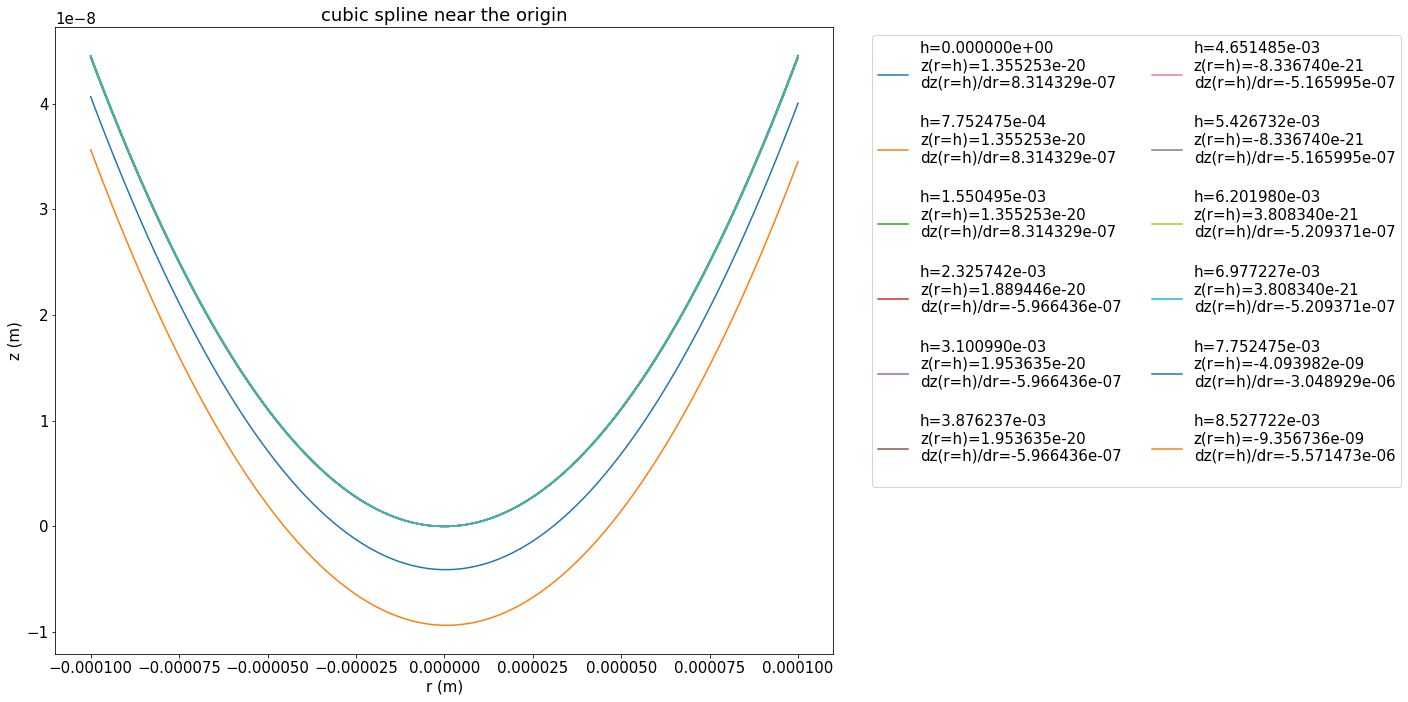

In [77]:
sor=np.copy(start_o[1])
fig,ax=plt.subplots(figsize=(20,10))
#zmax=max(start_o[0])
rmax=1e-4
for h in np.linspace(sor[0],sor[5],12):
    cs=find_local_eq(h,start_o)
    r=np.linspace(h-rmax,h+rmax,100)
    ax.plot(r-h,cs(r),label='h=%e\nz(r=h)=%e\ndz(r=h)/dr=%e\n'%(h, cs(h), cs(h,1)))
    
ax.legend(bbox_to_anchor=(1.04,1),loc='upper left',ncol=2)
ax.set_xlabel('r (m)')
ax.set_ylabel('z (m)')
ax.set_title('cubic spline near the origin')
plt.tight_layout()
plt.savefig('step0_cs')
plt.show

In [13]:
soz=np.copy(start_o[0])
signs=np.random.choice([-1,1],99)
dz=signs*5e-7
soz[1:]+=dz


[0.00000000e+00 6.41464646e-05 1.28792929e-04 1.94439394e-04
 2.59085859e-04 3.23732323e-04 3.87378788e-04 4.53025253e-04
 5.16671717e-04 5.81318182e-04 6.46964646e-04 7.11611111e-04
 7.76257576e-04 8.40904040e-04 9.05550505e-04 9.70196970e-04
 1.03384343e-03 1.09848990e-03 1.16313636e-03 1.22878283e-03
 1.29342929e-03 1.35707576e-03 1.42172222e-03 1.48636869e-03
 1.55101515e-03 1.61566162e-03 1.68030808e-03 1.74595455e-03
 1.81060101e-03 1.87524747e-03 1.93989394e-03 2.00454040e-03
 2.06918687e-03 2.13383333e-03 2.19847980e-03 2.26312626e-03
 2.32677273e-03 2.39241919e-03 2.45706566e-03 2.52071212e-03
 2.58535859e-03 2.65000505e-03 2.71565152e-03 2.78029798e-03
 2.84494444e-03 2.90859091e-03 2.97423737e-03 3.03788384e-03
 3.10353030e-03 3.16717677e-03 3.23182323e-03 3.29746970e-03
 3.36211616e-03 3.42576263e-03 3.49040909e-03 3.55605556e-03
 3.62070202e-03 3.68534848e-03 3.74999495e-03 3.81364141e-03
 3.87928788e-03 3.94293434e-03 4.00758081e-03 4.07322727e-03
 4.13787374e-03 4.202520

<function matplotlib.pyplot.show(close=None, block=None)>

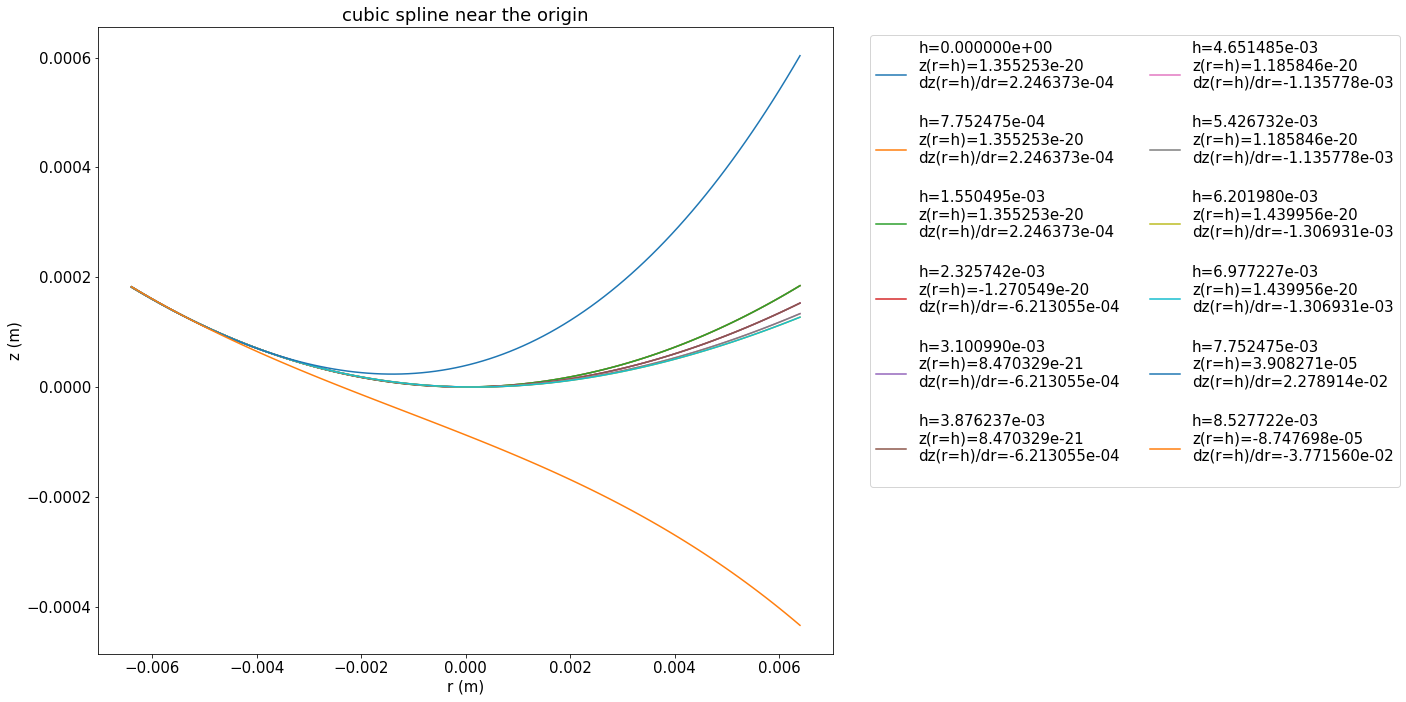

In [75]:
fig,ax=plt.subplots(figsize=(20,10))
rmax=max(start_o[0])
#rmax=1e-4
for h in np.linspace(sor[0],sor[5],12):
    cs=find_local_eq(h,[soz,sor])
    r=np.linspace(h-rmax,h+rmax,100)
    ax.plot(r-h,cs(r),label='h=%e\nz(r=h)=%e\ndz(r=h)/dr=%e\n'%(h, cs(h), cs(h,1)))
    
ax.legend(bbox_to_anchor=(1.04,1),loc='upper left',ncol=2)
ax.set_xlabel('r (m)')
ax.set_ylabel('z (m)')
ax.set_title('cubic spline near the origin')
plt.tight_layout()
plt.savefig('step1_cs')
plt.show